# 👹 Fera Formidável 4.2

> Atividade realizada em dupla: Caio Ruas (24010) e Thalles Cansi (24006)

Nessa fera, o objetivo era implementar uma estratégia de parada antecipada em uma rede neural feita em python puro ou no processo desenvolvido em disciplina envolvendo o `PyTorch`.

Em redes neurais, treinar por um número excessivo de épocas pode levar ao *overfitting* [1]. Isso significa que a rede começa a memorizar os dados de treinamento, incluindo ruídos e detalhes específicos, em vez de aprender os padrões gerais. Como resultado, o desempenho em dados de treinamento melhora continuamente, mas a capacidade de generalizar para dados novos e não vistos diminui significativamente.

Para evitar o *overfitting*, uma técnica eficaz é a parada antecipada (*early stopping*) [2]. Durante o treinamento, além do conjunto de treinamento, utilizamos um conjunto de validação, que a rede nunca viu antes. Monitoramos o desempenho da rede nesse conjunto de validação a cada época. Inicialmente, o desempenho tanto no treinamento quanto na validação tende a melhorar. No entanto, se o desempenho no conjunto de validação para de melhorar ou começa a piorar enquanto o desempenho no treinamento continua a aumentar, isso indica que o *overfitting* está começando a ocorrer. Nesse ponto, aplicamos a parada antecipada, interrompendo o treinamento para "capturar" o modelo em um estado onde ele ainda generaliza bem, antes de se especializar demais nos dados de treinamento.

Sendo assim, será aplicado o conceito de parada antecipada em uma rede neural simples, modificando o código da rede neural em python puro feito na disciplina.

> A rede neural feita durante a disciplina foi utilizada como base para a implementação das novas funções de ativação. Neste notebook, está presente apenas a versão adaptada ao objetivo da atividade, com as funções de ativação modificadas.

## 🔢 Valor

Esta é a classe Valor, que representa um valor numérico com suporte a diferenciação automática. Ela possui métodos para operações matemáticas, como adição, subtração, multiplicação e exponenciação, além de métodos para calcular a função sigmoide e backpropagation. É notório lembrar que realiza-se os cálculos mesmo com ordem invertida, onde o objeto Valor pode ser o primeiro ou segundo operando.

In [1]:
import math

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __gt__(self, outro_valor):
        """Realiza a operação: self > outro_valor"""
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        data = 1.0 if self.data > outro_valor.data else 0.0
        return Valor(data)
    
    def __ge__(self, outro_valor):
        """Realiza a operação: self >= outro_valor"""
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        data = 1.0 if self.data >= outro_valor.data else 0.0
        return Valor(data)

    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

## 🤓 Neurônio

A classe Neurônio representa um neurônio em uma rede neural. Ela possui pesos e um viés, que são inicializados aleatoriamente. O neurônio calcula a saída usando a função sigmoide e realiza o backpropagation para atualizar os pesos e o viés com base no erro da previsão.

In [2]:
import random

class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

## 🎂 Camada

A classe Camada representa uma camada de neurônios em uma rede neural. Ela possui um número específico de neurônios e é responsável por calcular a saída da camada com base nas entradas recebidas. Realiza o forward pass e agrega os parametros de cada neurônio.

In [3]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

## 🧠 MLP

Por fim, nossa última classe da nossa rede neural é a `MLP` (Multi-Layer Perceptron). Ela representa uma rede neural com múltiplas camadas. A `MLP` organiza as camadas da rede, permitindo a passagem forward dos dados e a agregação dos parâmetros de todas as camadas.

In [4]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

## ⚡ Modificando o código de treinamento

Para implementar a parada antecipada, foi necessário modificar a função responsável pelo treinamento da rede neural em épocas. A ideia é monitorar o desempenho da rede em um conjunto de validação e interromper o treinamento quando o desempenho começar a piorar.

In [5]:
def otimizacao_em_epocas(
    mlp: MLP,
    x_train: list,
    y_true_train: list,
    x_val: list,
    y_true_val: list,
    num_epocas: int,
    taxa_de_aprendizado: float = 0.01,
    paciencia: int = 10
) -> tuple:
    """
    Realiza a otimização do MLP em épocas, utilizando o algoritmo de backpropagation.
    
    Args:
        `mlp` (`MLP`): O modelo MLP a ser treinado.
        `x_train` (list): Lista de dados de entrada para o treinamento.
        `y_true_train` (list): Lista de rótulos verdadeiros para o treinamento.
        `x_val` (list): Lista de dados de entrada para a validação.
        `y_true_val` (list): Lista de rótulos verdadeiros para a validação.
        `num_epocas` (int): Número de épocas para o treinamento.
        `taxa_de_aprendizado` (float): Taxa de aprendizado para a atualização dos pesos.
        `paciencia` (int): Número de épocas sem melhoria na validação antes de interromper o treinamento.
        
    Returns:
        `tuple`: Tupla contendo duas listas. `train_losses` que é a lista de perdas de treinamento ao longo das épocas e `val_losses` que é a lista de perdas de validação ao longo das épocas.
            
    """
    train_losses = []
    val_losses = []

    for epoca in range(num_epocas):
        if len(val_losses) > paciencia:
            houve_melhoria = False
            for i in range(1, paciencia + 1):
                if val_losses[-i] < val_losses[-i - 1]:
                    houve_melhoria = True
                    break
            if not houve_melhoria:
                print(
                    f"Validação: Erro não diminuiu nas últimas {paciencia} épocas, interrompendo treinamento."
                )
                return train_losses, val_losses
            
        y_pred_train = []
        for exemplo in x_train:
            previsao = mlp(exemplo)
            y_pred_train.append(previsao)

        erros_train = []
        for yt, yp in zip(y_true_train, y_pred_train):
            residuo = yp - yt
            erro_quadratico = residuo**2
            erros_train.append(erro_quadratico)
        loss_train = sum(erros_train)

        y_pred_val = []
        for exemplo in x_val:
            previsao = mlp(exemplo)
            y_pred_val.append(previsao)

        erros_val = []
        for yt, yp in zip(y_true_val, y_pred_val):
            residuo = yp - yt
            erro_quadratico = residuo**2
            erros_val.append(erro_quadratico)
        loss_val = sum(erros_val)

        for p in mlp.parametros():
            p.grad = 0

        loss_train.propagar_tudo()

        for p in mlp.parametros():
            p.data = p.data - p.grad * taxa_de_aprendizado

        train_losses.append(loss_train.data)
        val_losses.append(loss_val.data)

        print(
            f"Época {epoca}, Loss Treino: {loss_train.data:.4f}, Loss Validação: {loss_val.data:.4f}"
        )

    return train_losses, val_losses

Podemos observar que o critério de parada antecipada é baseado na métrica de erro do conjunto de validação. Se o erro do conjunto de validação não melhorar por 10 épocas consecutivas, o treinamento é interrompido.

Vamos agora importar um banco de dados e aplicar a parada antecipada na rede neural. Vamos utilizar o dataset de Íris, que é um conjunto de dados clássico em aprendizado de máquina. Ele contém informações sobre diferentes espécies de flores Íris, com características como comprimento e largura das pétalas e sépalas.

Vamos importar as bibliotecas necessárias e carregar o dataset de Íris. Em seguida, vamos dividir os dados em conjuntos de treinamento e validação, normalizar os dados e treinar a rede neural com parada antecipada. Só lembrando que vamos usar uma seed para garantir a reprodutibilidade dos resultados.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

seed = 12
random.seed(seed)

Beleza, agora que importamos as bibliotecas necessárias, vamos carregar o dataset de Íris.

In [7]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Agora que carregamos, vamos dividir os dados em conjuntos de treinamento e validação. Vamos usar 80% dos dados para treinamento e 20% para validação. Vamos retirar também a coluna de rótulos, que contém as classes das flores, pois apenas precisamos das características para treinar a rede neural. Não é um problema de classificação, mas sim de regressão, onde o objetivo é prever um valor contínuo com base nas características das flores. Neste caso, preveremos a largura da pétala com base nas outras características.

In [8]:
iris = iris.drop(columns=["species"])

x = iris.drop(columns=["petal_width"]).values.tolist()
y = iris["petal_width"].values.tolist()

porcentagem_treino = 0.8

Show! Agora que dividimos os dados, vamos treinar a nossa rede neural e verificar se ocorre a parada antecipada. Vamos definir o número de épocas, a taxa de aprendizado e o critério de parada antecipada. A ideia é monitorar o erro no conjunto de validação e interromper o treinamento se o erro não melhorar por um certo número de épocas consecutivas.

In [ ]:
NUM_DADOS_DE_ENTRADA = 3
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]
NUM_EPOCAS = 100
TAXA_DE_APRENDIZADO = 0.05
PACIENCIA = 10

num_treino = int(len(x) * porcentagem_treino)

x_train = x[:num_treino]
y_true_train = y[:num_treino]
x_val = x[num_treino:]
y_true_val = y[num_treino:]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA])

train_losses, val_losses = otimizacao_em_epocas(
    minha_mlp,
    x_train,
    y_true_train,
    x_val,
    y_true_val,
    NUM_EPOCAS,
    TAXA_DE_APRENDIZADO,
    PACIENCIA,
)

train_losses_log = [math.log10(loss) for loss in train_losses]
val_losses_log = [math.log10(loss) for loss in val_losses]

Época 0, Loss Treino: 94.4957, Loss Validação: 74.9718
Época 1, Loss Treino: 60.4538, Loss Validação: 39.0753
Época 2, Loss Treino: 60.1203, Loss Validação: 38.1133
Época 3, Loss Treino: 59.9361, Loss Validação: 37.5105
Época 4, Loss Treino: 59.8151, Loss Validação: 37.0886
Época 5, Loss Treino: 59.7258, Loss Validação: 36.7745
Época 6, Loss Treino: 59.6537, Loss Validação: 36.5319
Época 7, Loss Treino: 59.5905, Loss Validação: 36.3407
Época 8, Loss Treino: 59.5312, Loss Validação: 36.1888
Época 9, Loss Treino: 59.4725, Loss Validação: 36.0690
Época 10, Loss Treino: 59.4127, Loss Validação: 35.9758
Época 11, Loss Treino: 59.3514, Loss Validação: 35.9045
Época 12, Loss Treino: 59.2895, Loss Validação: 35.8496
Época 13, Loss Treino: 59.2275, Loss Validação: 35.8051
Época 14, Loss Treino: 59.1652, Loss Validação: 35.7664
Época 15, Loss Treino: 59.1015, Loss Validação: 35.7323
Época 16, Loss Treino: 59.0356, Loss Validação: 35.7035
Época 17, Loss Treino: 58.9667, Loss Validação: 35.6814
Ép

Excelente, podemos observar que o critério de parada antecipada foi ativado na época 29. Isso significa que o erro no conjunto de validação não melhorou por 10 épocas consecutivas, indicando que a rede neural começou a se especializar demais nos dados de treinamento e não estava mais generalizando bem.

Vamos agora plotar o erro de treinamento e validação ao longo das épocas para visualizar o desempenho da rede neural durante o treinamento. Isso nos ajudará a entender melhor como a parada antecipada afetou o processo de treinamento.

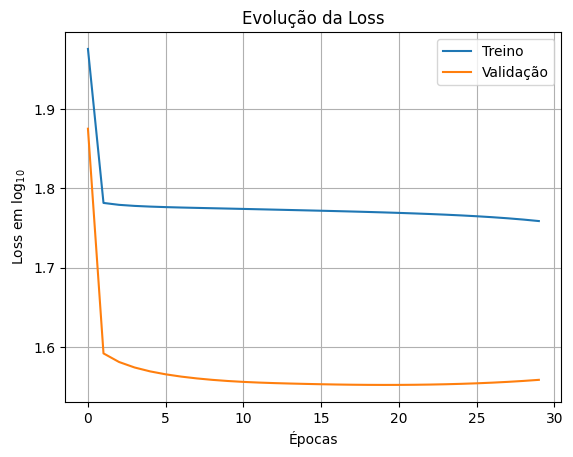

In [10]:
plt.plot(train_losses_log, label="Treino")
plt.plot(val_losses_log, label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss em $\log_{10}$")
plt.title("Evolução da Loss")
plt.legend()
plt.grid()
plt.show()

Podemos observar com esse gráfico que o erro de validação começou a aumentar após a época 19, enquanto o erro de treinamento continuou a diminuir. Isso confirma que a parada antecipada foi eficaz em evitar o *overfitting* e capturar o modelo em um estado onde ele ainda generaliza bem.

Isso conclui a implementação da parada antecipada em uma rede neural simples. Essa técnica é fundamental para evitar o *overfitting* e garantir que o modelo generalize bem para novos dados. A parada antecipada é uma prática comum em treinamento de redes neurais e pode ser aplicada em diversos cenários de aprendizado de máquina.

## 📖 Referências

[1] BKASHYAP, P. Early Stopping in Deep Learning: A Simple Guide to Prevent Overfitting. Disponível em: <https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e>. 

[2] Cyborg. What is Early Stopping in Deep Learning? Disponível em: <https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf>.